# Example 4: Use of surface model Oh92 and canopy model SSRT (synthetic data set)

## 1. Requirements

- Installation of SenSE

## 2. Oh92+SSRT retrieval of soil moisture

First of all, we need to import several packages

In [1]:
import numpy as np
#from sense.surface import Dubois95
from sense.util import f2lam
from sense.model import RTModel
from sense.soil import Soil
from sense.canopy import OneLayer
import matplotlib.pyplot as plt
import random
from sense.surface import Oh92, Oh04
from scipy.optimize import minimize

Define which are RT models should be used

In [2]:
# Choose models (surface: Oh92; canopy: SSRT (turbid_isotropic))
#------------------------------------------------------------------
canopy = 'turbid_isotropic'
surface = 'Oh92'
models = {'surface' : surface, 'canopy' : canopy}
pol='vv'

Define model parameters with a random time series of soil moisture values

In [3]:
# model parameter Oh92
#----------------------
freq = 5.405
clay = 0.0738
sand = 0.2408
bulk = 1.45
theta = np.deg2rad(35)
s = 0.013
sm = np.random.uniform(low=0.05, high=0.35, size=(50,))

# model parameter SSRT
#---------------------
d = 0.55
tau = 0.45
ke = tau/d
omega = 0.175
ks=omega*ke


Initialize and run the RT model to create a synthetic backscatter time series based on different soil moisture values

In [4]:
# run model to produce backscatter
#----------------------------------
S = Soil(f=freq, s=s, mv=sm, sand=sand, clay=clay, bulk=bulk)
C = OneLayer(ke_h=ke, ke_v=ke, d=d, ks_v=ks, ks_h=ks, canopy=models['canopy'])
RT = RTModel(theta=theta, models=models, surface=S, canopy=C, freq=freq)
RT.sigma0()
back_vv = RT.stot['vv']
back_hv = RT.stot['hv']

Let's put some uncertainty on the synthetic backscatter time series

In [5]:
# put uncertainty on backscatter
unc = np.random.uniform(low=-np.mean(back_vv)*0.15, high=np.mean(back_vv)*0.15, size=(len(back_vv),))
back_vv = back_vv - unc

Define some helper function so that we can run the RT model in an inversion process. The aim is to provide backscatter to the RT model thus we can retrieve soil moisture values 

In [6]:
# helper function retrieval
#-----------------
def run_model(dic, models):
    # surface
    soil = Soil(mv=dic['mv'], s=dic['s'], clay=dic['clay'], sand=dic['sand'], f=dic['f'], bulk=dic['bulk'])

    # canopy
    can = OneLayer(canopy=dic['canopy'], ke_h=dic['ke'], ke_v=dic['ke'], d=dic['d'], ks_h = dic['omega']*dic['ke'],
                   ks_v = dic['omega']*dic['ke'])

    S = RTModel(surface=soil, canopy=can, models=models, theta=dic['theta'], freq=dic['f'])
    S.sigma0()
    return S.__dict__['stot']['vv'[::-1]], S.__dict__['stot']['vh'[::-1]]

def solve_fun(VALS, var_opt, dic, models):

    for i in range(len(var_opt)):
        dic[var_opt[i]] = VALS[i]

    vv, vh = run_model(dic, models)

    return vv, vh

def fun_opt(VALS, var_opt, dic, models, pol):
    if pol == 'vv':
        return(np.nansum(np.square(solve_fun(VALS, var_opt, dic, models)[0]-dic['vv'])))
    elif pol == 'vh':
        return(np.nansum(np.square(solve_fun(VALS, var_opt, dic, models)[1]-dic['vh'])))
    elif pol == 'vv_vh':
        return(np.nansum(np.square((solve_fun(VALS, var_opt, dic, models)[0]-dic['vv'])/2+(solve_fun(VALS, var_opt, dic, models)[1]-dic['vh'])/2)))

Now we can run the inversion process to estimate soil moisture based on a synthetic radar backscatter time series

In [7]:
# run soil moisture retrieval
#-----------------

dic = {"mv":0.2, "s":s, "clay":clay, "sand":sand, "f":freq, "bulk":bulk, "canopy":canopy, "d":d, 
       "ke":ke, "vv":back_vv, "vh":back_hv, "theta":theta, "omega": omega}

var_opt = ['mv']
guess = [0.2]
bounds = [(0.05,0.35)]

method = 'L-BFGS-B'

sm_retrieved = []

for i,ii in enumerate(back_vv):
    
    dic = {"mv":0.2, "s":s, "clay":clay, "sand":sand, "f":freq, "bulk":bulk, "canopy":canopy, "d":d, 
       "ke":ke, "vv":back_vv[i], "vh":back_hv[i], "theta":theta, "omega": omega}
    
    res = minimize(fun_opt,guess,args=(var_opt, dic, models, pol),bounds=bounds, method=method)

    fun_opt(res.x, var_opt, dic, models, 'vv')
    sm_retrieved.append(res.x[0])


Let's see how the original soil moisture compares to the model retrieved soil moisture (remember we put some uncertainty on the synthetic radar backscatter time series)

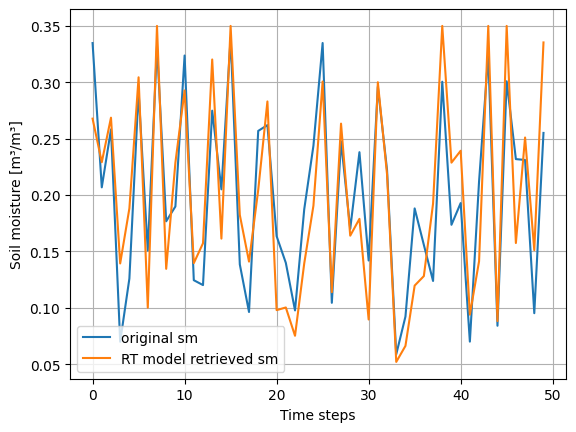

In [8]:
plt.plot(sm, label='original sm')
plt.plot(sm_retrieved, label='RT model retrieved sm')
plt.xlabel('Time steps')
plt.ylabel('Soil moisture [m³/m³]')
plt.grid()
plt.legend()

In [9]:
diff = sm - sm_retrieved
diff_average = np.sum(abs(diff))/len(diff)
print(diff)
print(diff_average)

[ 0.06701473 -0.02227853 -0.01037848 -0.06943235 -0.06221347 -0.01257499
  0.05063934 -0.01814949  0.04215853 -0.03886211  0.03096607 -0.01514209
 -0.0370781  -0.04540436  0.04370535 -0.01058383 -0.04384273 -0.04470592
  0.0523873  -0.02098578  0.06558368  0.0395819   0.02250278  0.04800581
  0.05317183  0.03416386 -0.00944465 -0.01577255  0.0060557   0.05912046
  0.05232236 -0.00398901  0.00378479  0.0067642   0.02599513  0.06844459
  0.02767383 -0.06854925 -0.04948814 -0.0551279  -0.04641099 -0.02391477
  0.07089544 -0.02548163 -0.00414568 -0.0490847   0.0744448  -0.01992074
 -0.05595654 -0.08025831]
0.03809119158664622
